# Logistic 回归——Otto商品分类

我们以Kaggle 2015年举办的Otto Group Product Classification Challenge竞赛数据为例，分别调用缺省参数LogisticRegression、LogisticRegression + GridSearchCV以及LogisticRegressionCV进行参数调优。实际应用中LogisticRegression + GridSearchCV或LogisticRegressionCV任选一个即可。

Otto数据集是著名电商Otto提供的一个多类商品分类问题，类别数=9. 每个样本有93维数值型特征（整数，表示某种事件发生的次数，已经进行过脱敏处理）。 竞赛官网：https://www.kaggle.com/c/otto-group-product-classification-challenge/data


第一名：https://www.kaggle.com/c/otto-group-product-classification-challenge/discussion/14335
第二名：http://blog.kaggle.com/2015/06/09/otto-product-classification-winners-interview-2nd-place-alexander-guschin/

In [1]:
# 首先 import 必要的模块
import pandas as pd 
import numpy as np

from sklearn.model_selection import GridSearchCV

#竞赛的评价指标为logloss
from sklearn.metrics import log_loss  

from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

## 读取数据 & 数据探索

In [2]:
# 读取数据
# path to where the data lies
dpath = './data/'
train = pd.read_csv(dpath +"Otto_train.csv")
train.head()

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
0,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Class_1
1,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
2,3,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
3,4,1,0,0,1,6,1,5,0,0,...,0,1,2,0,0,0,0,0,0,Class_1
4,5,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,Class_1


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61878 entries, 0 to 61877
Data columns (total 95 columns):
id         61878 non-null int64
feat_1     61878 non-null int64
feat_2     61878 non-null int64
feat_3     61878 non-null int64
feat_4     61878 non-null int64
feat_5     61878 non-null int64
feat_6     61878 non-null int64
feat_7     61878 non-null int64
feat_8     61878 non-null int64
feat_9     61878 non-null int64
feat_10    61878 non-null int64
feat_11    61878 non-null int64
feat_12    61878 non-null int64
feat_13    61878 non-null int64
feat_14    61878 non-null int64
feat_15    61878 non-null int64
feat_16    61878 non-null int64
feat_17    61878 non-null int64
feat_18    61878 non-null int64
feat_19    61878 non-null int64
feat_20    61878 non-null int64
feat_21    61878 non-null int64
feat_22    61878 non-null int64
feat_23    61878 non-null int64
feat_24    61878 non-null int64
feat_25    61878 non-null int64
feat_26    61878 non-null int64
feat_27    61878 non-null i

In [4]:
## 各属性的统计特性
train.describe()

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93
count,61878.000000,61878.00000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,...,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000
mean,30939.500000,0.38668,0.263066,0.901467,0.779081,0.071043,0.025696,0.193704,0.662433,1.011296,...,0.070752,0.532306,1.128576,0.393549,0.874915,0.457772,0.812421,0.264941,0.380119,0.126135
std,17862.784315,1.52533,1.252073,2.934818,2.788005,0.438902,0.215333,1.030102,2.255770,3.474822,...,1.151460,1.900438,2.681554,1.575455,2.115466,1.527385,4.597804,2.045646,0.982385,1.201720
min,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15470.250000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,30939.500000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,46408.750000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,61878.000000,61.00000,51.000000,64.000000,70.000000,19.000000,10.000000,38.000000,76.000000,43.000000,...,76.000000,55.000000,65.000000,67.000000,30.000000,61.000000,130.000000,52.000000,19.000000,87.000000


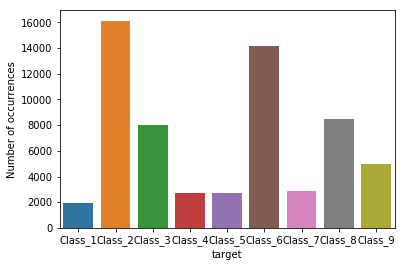

In [5]:
# Target 分布，看看各类样本分布是否均衡
sns.countplot(train.target);
pyplot.xlabel('target');
pyplot.ylabel('Number of occurrences');

各类样本不均衡。交叉验证对分类任务缺省的是采用StratifiedKFold，在每折采样时根据各类样本按比例采样

## 特征编码

In [3]:
# 将类别字符串变成数字
# drop ids and get labels
y_train = train['target']   #形式为Class_x
y_train = y_train.map(lambda s: s[6:])
y_train = y_train.map(lambda s: int(s)-1)

train = train.drop(["id", "target"], axis=1)
X_train = np.array(train)

#如果计算资源有限，也可只取少量样本，如取前1000个样本
#（分类中其实还需要确保取出来的这部分样本各类样本的比例和总体一致）
#n_trains = 1000
#y_train = train.label.values[:n_trains]

#或者考虑用train_test_split而不是交叉验证来验证模型性能

## 数据预处理

In [4]:
# 数据标准化
from sklearn.preprocessing import StandardScaler

# 初始化特征的标准化器
ss_X = StandardScaler()

# 分别对训练和测试数据的特征进行标准化处理
X_train = ss_X.fit_transform(X_train)
#X_test = ss_X.transform(X_test)


/Users/qing/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## 模型训练

### default Logistic Regression

In [8]:
from sklearn.linear_model import LogisticRegression
lr= LogisticRegression()

In [10]:
# 交叉验证用于评估模型性能和进行参数调优（模型选择）
#分类任务中交叉验证缺省是采用StratifiedKFold
from sklearn.cross_validation import cross_val_score
loss = cross_val_score(lr, X_train, y_train, cv=5, scoring='neg_log_loss')
print 'logloss of each fold is: ',-loss
print'cv logloss is:', -loss.mean()

logloss of each fold is:  [ 0.67686698  0.68182075  0.66838086  0.6662869   0.67439387]
cv logloss is: 0.673549871424


### 正则化的 Logistic Regression及参数调优

logistic回归的需要调整超参数有：C（正则系数，一般在log域（取log后的值）均匀设置候选参数）和正则函数penalty（L2/L1） 
目标函数为：J = sum(logloss(f(xi), yi)) + C* penalty 

在sklearn框架下，不同学习器的参数调整步骤相同：
设置候选参数集合
调用GridSearchCV
调用fit

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

#需要调优的参数
# 请尝试将L1正则和L2正则分开，并配合合适的优化求解算法（slover）
#tuned_parameters = {'penalty':['l1','l2'],
#                   'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
#                   }
penaltys = ['l1','l2']
Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
tuned_parameters = dict(penalty = penaltys, C = Cs)

lr_penalty= LogisticRegression()
grid= GridSearchCV(lr_penalty, tuned_parameters,cv=5, scoring='neg_log_loss')
grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [9]:
# view the complete results (list of named tuples)
grid.cv_results_

/Users/qing/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/qing/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/qing/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/qing/anaconda2/lib/python2.7/

{'mean_fit_time': array([  1.93511062,   5.99620657,   5.26897659,  10.01246262,
         15.74666104,  15.71642375,  27.90830598,  20.76507196,
         37.48180237,  22.21065221,  36.81701975,  22.43034906,
         37.2483572 ,  22.94229341]),
 'mean_score_time': array([ 0.01501718,  0.01509032,  0.01391201,  0.01647058,  0.01643734,
         0.01428461,  0.01579723,  0.01449585,  0.015205  ,  0.0126554 ,
         0.01449461,  0.01259732,  0.01442018,  0.0124156 ]),
 'mean_test_score': array([-1.177056  , -1.02651724, -0.77504707, -0.76020957, -0.68194978,
        -0.68690556, -0.67238102, -0.67355004, -0.67187999, -0.67184425,
        -0.67190296, -0.6718333 , -0.67190395, -0.67187363]),
 'mean_train_score': array([-1.17597192, -1.02389825, -0.7709288 , -0.75433198, -0.6725468 ,
        -0.67728075, -0.66042996, -0.66191617, -0.65922489, -0.65940444,
        -0.65913019, -0.65909357, -0.65911419, -0.65906463]),
 'param_C': masked_array(data = [0.001 0.001 0.01 0.01 0.1 0.1 1 1 10 1

In [14]:
# examine the best model
print(-grid.best_score_)
print(grid.best_params_)

0.671833302852
{'penalty': 'l2', 'C': 100}


如果最佳值在候选参数的边缘，最好再尝试更大的候选参数或更小的候选参数，直到找到拐点。
l2, c=100

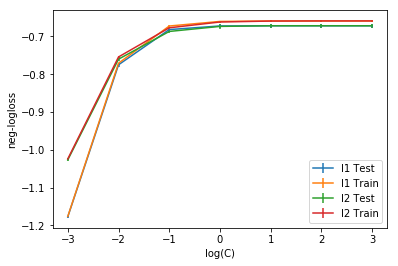

In [74]:
#pd.DataFrame(grid.cv_results_).to_csv('LogisticGridSearchCV_Otto.csv')
#cvresult = pd.DataFrame.from_csv('LogisticGridSearchCV_Otto.csv')
#test_means = cv_results['mean_test_score']
#test_stds = cv_results['std_test_score'] 
#train_means = cvresult['mean_train_score']
#train_stds = cvresult['std_train_score'] 


# plot CV误差曲线
test_means = grid.cv_results_[ 'mean_test_score' ]
test_stds = grid.cv_results_[ 'std_test_score' ]
train_means = grid.cv_results_[ 'mean_train_score' ]
train_stds = grid.cv_results_[ 'std_train_score' ]


# plot results
n_Cs = len(Cs)
number_penaltys = len(penaltys)
test_scores = np.array(test_means).reshape(n_Cs,number_penaltys)
train_scores = np.array(train_means).reshape(n_Cs,number_penaltys)
test_stds = np.array(test_stds).reshape(n_Cs,number_penaltys)
train_stds = np.array(train_stds).reshape(n_Cs,number_penaltys)

x_axis = np.log10(Cs)
for i, value in enumerate(penaltys):
    #pyplot.plot(log(Cs), test_scores[i], label= 'penalty:'   + str(value))
    pyplot.errorbar(x_axis, test_scores[:,i], yerr=test_stds[:,i] ,label = penaltys[i] +' Test')
    pyplot.errorbar(x_axis, train_scores[:,i], yerr=train_stds[:,i] ,label = penaltys[i] +' Train')
    
pyplot.legend()
pyplot.xlabel( 'log(C)' )                                                                                                      
pyplot.ylabel( 'neg-logloss' )
pyplot.savefig('LogisticGridSearchCV_C.png' )

pyplot.show()

上图给出了L1正则和L2正则下、不同正则参数C对应的模型在训练集上测试集上的正确率（score）。可以看出在训练集上C越大（正则越少）的模型性能越好；但在测试集上当C=100时性能最好（L1正则和L2正则均是）

### 用LogisticRegressionCV实现正则化的 Logistic Regression

### L1正则

In [12]:
from sklearn.linear_model import LogisticRegressionCV

Cs = [1, 10,100,1000]

# 大量样本（6W+）、高维度（93），L1正则 --> 可选用saga优化求解器(0.19版本新功能)
# LogisticRegressionCV比GridSearchCV快
lrcv_L1 = LogisticRegressionCV(Cs=Cs, cv = 5, scoring='neg_log_loss', penalty='l1', solver='liblinear', multi_class='ovr')
lrcv_L1.fit(X_train, y_train)    

LogisticRegressionCV(Cs=[1, 10, 100, 1000], class_weight=None, cv=5,
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=1, penalty='l1',
           random_state=None, refit=True, scoring='neg_log_loss',
           solver='liblinear', tol=0.0001, verbose=0)

In [13]:
lrcv_L1.scores_

{0: array([[-0.08352368, -0.08351874, -0.08351932, -0.0835193 ],
        [-0.08855243, -0.08870811, -0.08872645, -0.08872815],
        [-0.08310835, -0.08322735, -0.08324098, -0.08324238],
        [-0.0821809 , -0.08218971, -0.08219017, -0.08219025],
        [-0.08079014, -0.08076733, -0.08076566, -0.08076557]]),
 1: array([[-0.31682739, -0.31682268, -0.31682257, -0.31682187],
        [-0.32032738, -0.32039225, -0.32039847, -0.32039874],
        [-0.31523852, -0.31526591, -0.31526951, -0.31527038],
        [-0.31668845, -0.31669211, -0.31669289, -0.31669223],
        [-0.31923648, -0.3192882 , -0.31929246, -0.31929285]]),
 2: array([[-0.26140663, -0.26141912, -0.26142148, -0.26142154],
        [-0.261854  , -0.26188003, -0.26188282, -0.26188393],
        [-0.26767802, -0.26772406, -0.26773324, -0.2677292 ],
        [-0.26380728, -0.26382864, -0.26383156, -0.26383158],
        [-0.26326535, -0.26328817, -0.26329084, -0.26329134]]),
 3: array([[-0.13062825, -0.13080908, -0.13082942, -0.1

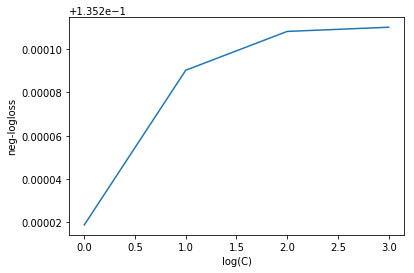

In [70]:
# scores_：dict with classes as the keys, and the values as the grid of scores obtained during cross-validating each fold,
# Each dict value has shape (n_folds, len(Cs))
n_Cs = len(Cs)
n_classes = 9
scores =  np.zeros((n_classes,n_Cs))

for j in range(n_classes):
        scores[j][:] = np.mean(lrcv_L1.scores_[j],axis = 0)
    
mse_mean = -np.mean(scores, axis = 0)
pyplot.plot(np.log10(Cs), mse_mean.reshape(n_Cs,1)) 
#plt.plot(np.log10(reg.Cs)*np.ones(3), [0.28, 0.29, 0.30])
pyplot.xlabel('log(C)')
pyplot.ylabel('neg-logloss')
pyplot.show()

#print ('C is:',lr_cv.C_)  #对多类分类问题，每个类别的分类器有一个C


这个score似乎和GridSearchCV得到的Score不一样

In [ ]:
lrcv_L1.coef_

惩罚不够，没有稀疏系数

### L2正则

In [5]:
from sklearn.linear_model import LogisticRegressionCV

Cs = [1, 10,100,1000]

# 大量样本（6W+）、高维度（93），L2正则 --> 缺省用lbfgs，为了和GridSeachCV比较，也用liblinear

lr_cv_L2 = LogisticRegressionCV(Cs=Cs, cv = 5, scoring='neg_log_loss', penalty='l2', solver='liblinear', multi_class='ovr')
lr_cv_L2.fit(X_train, y_train)    

LogisticRegressionCV(Cs=[1, 10, 100, 1000], class_weight=None, cv=5,
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
           random_state=None, refit=True, scoring='neg_log_loss',
           solver='liblinear', tol=0.0001, verbose=0)

In [6]:
lr_cv.scores_

{0: array([[-0.08350778, -0.08351508, -0.08351904, -0.08351952],
        [-0.08843242, -0.08868946, -0.08872516, -0.08872888],
        [-0.08309293, -0.08322307, -0.08324103, -0.0832429 ],
        [-0.08219928, -0.08218897, -0.0821904 , -0.08219058],
        [-0.08077456, -0.08076276, -0.0807651 , -0.08076537]]),
 1: array([[-0.31683143, -0.31682081, -0.31682044, -0.31682046],
        [-0.32034989, -0.32039856, -0.32040339, -0.32040501],
        [-0.31524611, -0.31526643, -0.31527065, -0.31526969],
        [-0.31669067, -0.31669   , -0.31669026, -0.31669034],
        [-0.31924003, -0.31929319, -0.3192987 , -0.31930054]]),
 2: array([[-0.26142898, -0.26141999, -0.26142016, -0.26142016],
        [-0.26187226, -0.2618826 , -0.26188465, -0.26188486],
        [-0.26763476, -0.26772384, -0.26773416, -0.26773516],
        [-0.26382995, -0.26383176, -0.26383281, -0.2638332 ],
        [-0.26330204, -0.26329121, -0.26329121, -0.26329116]]),
 3: array([[-0.1306382 , -0.1308083 , -0.13083052, -0.1

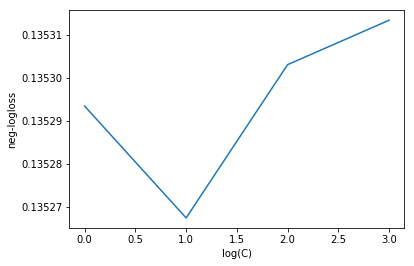

In [7]:
# dict with classes as the keys, and the values as the grid of scores obtained during cross-validating each fold,
# Each dict value has shape (n_folds, len(Cs))
n_Cs = len(Cs)
n_classes = 9
scores =  np.zeros((n_classes,n_Cs))

for j in range(n_classes):
        scores[j][:] = np.mean(lr_cv.scores_[j],axis = 0)
    
mse_mean = -np.mean(scores, axis = 0)
pyplot.plot(np.log10(Cs), mse_mean.reshape(n_Cs,1)) 
#plt.plot(np.log10(reg.Cs)*np.ones(3), [0.28, 0.29, 0.30])
pyplot.xlabel('log(C)')
pyplot.ylabel('neg-logloss')
pyplot.show()

#print ('C is:',lr_cv.C_)  #对多类分类问题，每个类别的分类器有一个C


In [8]:
from sklearn.linear_model import LogisticRegressionCV

Cs = [1, 10,100,1000]

# 大量样本（6W+）、高维度（93），L2正则 --> 缺省用lbfgs
# LogisticRegressionCV比GridSearchCV快
lrcv_L2 = LogisticRegressionCV(Cs=Cs, cv = 5, scoring='neg_log_loss', penalty='l2', multi_class='ovr')
lrcv_L2.fit(X_train, y_train)    

LogisticRegressionCV(Cs=[1, 10, 100, 1000], class_weight=None, cv=5,
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
           random_state=None, refit=True, scoring='neg_log_loss',
           solver='lbfgs', tol=0.0001, verbose=0)

In [11]:
lrcv_L2.scores_

{0: array([[-0.08350408, -0.08351795, -0.08351906, -0.08351913],
        [-0.08855341, -0.08870812, -0.08872599, -0.08872602],
        [-0.08314284, -0.08323216, -0.08324237, -0.0832424 ],
        [-0.08221991, -0.08219267, -0.08219213, -0.08219205],
        [-0.0807325 , -0.08076111, -0.08076424, -0.08076426]]),
 1: array([[-0.31682273, -0.31682131, -0.31682132, -0.31682128],
        [-0.32037305, -0.32040159, -0.32040171, -0.32040164],
        [-0.3152482 , -0.31526742, -0.31526695, -0.31526741],
        [-0.31668648, -0.316691  , -0.31669098, -0.31669127],
        [-0.31926347, -0.31929601, -0.31929551, -0.31929597]]),
 2: array([[-0.26141765, -0.26141826, -0.26141811, -0.26141815],
        [-0.26187469, -0.2618833 , -0.26188354, -0.26188343],
        [-0.26767706, -0.26772995, -0.26773643, -0.2677364 ],
        [-0.26382824, -0.26383129, -0.26383095, -0.26383164],
        [-0.26329748, -0.2632904 , -0.26329033, -0.26329027]]),
 3: array([[-0.13075342, -0.13082462, -0.13083402, -0.1

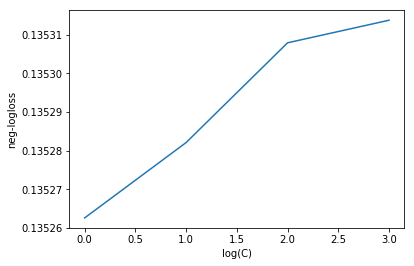

In [12]:
# dict with classes as the keys, and the values as the grid of scores obtained during cross-validating each fold,
# Each dict value has shape (n_folds, len(Cs))
n_Cs = len(Cs)
n_classes = 9
scores =  np.zeros((n_classes,n_Cs))

for j in range(n_classes):
        scores[j][:] = np.mean(lrcv_L2.scores_[j],axis = 0)
    
mse_mean = -np.mean(scores, axis = 0)
pyplot.plot(np.log10(Cs), mse_mean.reshape(n_Cs,1)) 
#plt.plot(np.log10(reg.Cs)*np.ones(3), [0.28, 0.29, 0.30])
pyplot.xlabel('log(C)')
pyplot.ylabel('neg-logloss')
pyplot.show()

#print ('C is:',lr_cv.C_)  #对多类分类问题，每个类别的分类器有一个C
